In [1]:
import sys
import os
import pandas as pd
import json
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

from src.preprocessing import (
    process_and_plot_fps, process_all_experiments, 
    get_total_time_per_trial, get_total_time_per_trial_phones, 
    calculate_phone_measurements, build_phones_dataset
    )

# Compute Datasets

## Zed and Force Plate

In [2]:
# Define file paths
oa_json_file_path = project_root + "/data/processed/older_adults/zed_frames_dict.json"
st_json_file_path = project_root + "/data/processed/students/zed_frames_dict.json"

# Load the JSON files
with open(oa_json_file_path, "r") as f:
    zed_frames_dict_older_adults = json.load(f)

with open(st_json_file_path, "r") as f:
    zed_frames_dict_students = json.load(f)

### Older Adults

Computing datasets with the default 30 second window

In [3]:
# Process all older adult data
older_adult_results = process_all_experiments(participant_type='older_adults', 
                                              zed_frames_dict=zed_frames_dict_older_adults)
older_adult_results.head(2)

Starting process_all_experiments with participant_type: older_adults
zed_frames_dict keys: ['ann_eyes_open1', 'ann_eyes_open3', 'ann_eyes_closed3', 'anna_eyes_open3', 'ann-m_eyes_open5', 'ann-m_eyes_closed5', 'avraham_eyes_open1', 'avraham_eyes_closed5', 'bat-sheva_eyes_open2', 'batya_eyes_open4', 'benny_eyes_open4', 'benny_eyes_closed5', 'dov_eyes_closed3', 'gita_eyes_open1', 'gita_eyes_closed2', 'gita_eyes_closed4', 'ilana_eyes_open1', 'ilana_eyes_open4', 'ilana_eyes_closed1', 'mazal_eyes_open2', 'michael_eyes_closed2', 'michael_eyes_closed3', 'miryam_eyes_closed1', 'mordehai_eyes_open2', 'naftali_eyes_open1', 'naftali_eyes_open4', 'naftali_eyes_open5', 'naomi_eyes_closed3', 'naomi_eyes_closed5', 'rahel_eyes_open4', 'raya_eyes_closed1', 'raya_eyes_closed4', 'tami_eyes_open4', 'tina_eyes_closed3', 'tova_eyes_open1', 'tova_eyes_open2', 'uri_eyes_open1', 'uri_eyes_open3', 'yaacov_eyes_open1', 'yaacov_eyes_closed1', 'yaacov_e_eyes_open5', 'yaacov_e_eyes_closed4', 'yaacov_e_eyes_closed5',

,participant name,state,trial,device,metric,value
0,ann,closed,1,ZED_COM,ML Range,3.067861
1,ann,closed,1,Force_Plate,ML Range,3.553300


### Students

In [4]:
# Process all student data
student_results = process_all_experiments('students', zed_frames_dict_students)
student_results.head(2)

Starting process_all_experiments with participant_type: students
zed_frames_dict keys: ['2_eyes_open1', '2_eyes_open2', '2_eyes_open4', '2_eyes_open5', '2_eyes_closed3', '2_eyes_closed5', '3_eyes_closed1', '3_eyes_closed3', '3_eyes_closed4', '5_eyes_open2', '5_eyes_open3', '8_eyes_open3', '8_eyes_open4', '8_eyes_closed1', '8_eyes_closed2', '8_eyes_closed4', '8_eyes_closed5', '9_eyes_closed2', '11_eyes_closed2', '13_eyes_open2', '14_eyes_closed4', '14_eyes_closed5', '16_eyes_open2', '18_eyes_closed2', '19_eyes_open1', '19_eyes_open3', '19_eyes_closed1', '19_eyes_closed3', '20_eyes_open4', '20_eyes_closed3', '20_eyes_closed5', '24_eyes_open1']
Processing data from: c:\fall_risk_analysis\data\raw\students

Processing participant: 1
  Processing ZED folder: 1_zed
    Processing files: 1_eyes_closed1.csv and 1_eyes_closed1.txt
    Using 50 frames for 1_eyes_closed1
    Processing files: 1_eyes_closed2.csv and 1_eyes_closed2.txt
    Using 50 frames for 1_eyes_closed2
    Processing files: 1_

,participant name,state,trial,device,metric,value
0,1,closed,1,ZED_COM,ML Range,2.673482
1,1,closed,1,Force_Plate,ML Range,2.804100


### Check trimmed signals length

### Older Adults

In [5]:
oa_total_time_df = get_total_time_per_trial("older_adults", zed_frames_dict_older_adults)
oa_total_time_df.head(2)

Extracting total time values for participant_type: older_adults


,participant name,trial name,total_time_zed,total_time_fp
0,ann,ann_eyes_closed1,29.929966,30.0
1,ann,ann_eyes_closed2,29.451202,30.0


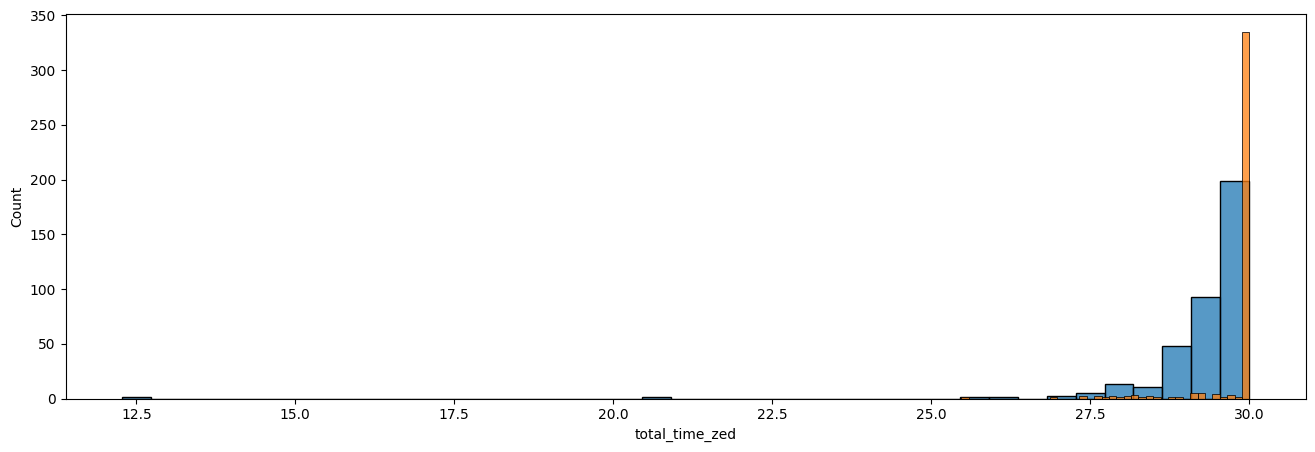

In [6]:
plt.figure(figsize=(16, 5))
sns.histplot(oa_total_time_df["total_time_zed"])
sns.histplot(oa_total_time_df["total_time_fp"])
# plt.xlim(22.5)
plt.show()

We have many trials below 30 seconds.  
Let's set 25 as the window duration instead.  
It seems that there are some trials lasted last than 25 seconds (outliers).  

In [7]:
for _, sample in oa_total_time_df.iterrows():
    zed_time = pd.to_numeric(sample["total_time_zed"], errors="coerce")
    if pd.notna(zed_time) and zed_time < 25.0:
        print(sample["trial name"])

dida_eyes_closed5
yossef_eyes_open3


### Students

In [8]:
st_total_time_df = get_total_time_per_trial("students", zed_frames_dict_students)
st_total_time_df.head(2)

Extracting total time values for participant_type: students


,participant name,trial name,total_time_zed,total_time_fp
0,1,1_eyes_closed1,29.945967,30.0
1,1,1_eyes_closed2,29.915998,30.0


Let's check what is the minimum trial time recorded with the force plate

In [9]:
st_total_time_df["total_time_fp"].min()

np.float64(29.989999999999995)

Very close to 30.  
Let's plot the zed durations now

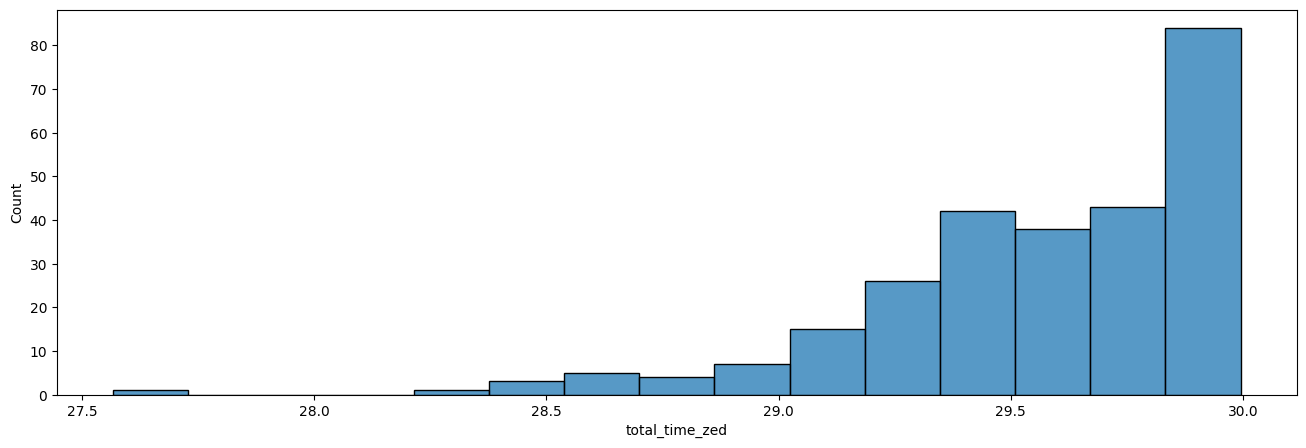

In [10]:
plt.figure(figsize=(16, 5))
sns.histplot(st_total_time_df["total_time_zed"])
plt.show()

We will use 25 seconds window instead of the deafualt 30 seconds as well.

### Re-compute the datasets

In [11]:
older_adult_results = process_all_experiments('older_adults', zed_frames_dict_older_adults, window_duration=25)

Starting process_all_experiments with participant_type: older_adults
zed_frames_dict keys: ['ann_eyes_open1', 'ann_eyes_open3', 'ann_eyes_closed3', 'anna_eyes_open3', 'ann-m_eyes_open5', 'ann-m_eyes_closed5', 'avraham_eyes_open1', 'avraham_eyes_closed5', 'bat-sheva_eyes_open2', 'batya_eyes_open4', 'benny_eyes_open4', 'benny_eyes_closed5', 'dov_eyes_closed3', 'gita_eyes_open1', 'gita_eyes_closed2', 'gita_eyes_closed4', 'ilana_eyes_open1', 'ilana_eyes_open4', 'ilana_eyes_closed1', 'mazal_eyes_open2', 'michael_eyes_closed2', 'michael_eyes_closed3', 'miryam_eyes_closed1', 'mordehai_eyes_open2', 'naftali_eyes_open1', 'naftali_eyes_open4', 'naftali_eyes_open5', 'naomi_eyes_closed3', 'naomi_eyes_closed5', 'rahel_eyes_open4', 'raya_eyes_closed1', 'raya_eyes_closed4', 'tami_eyes_open4', 'tina_eyes_closed3', 'tova_eyes_open1', 'tova_eyes_open2', 'uri_eyes_open1', 'uri_eyes_open3', 'yaacov_eyes_open1', 'yaacov_eyes_closed1', 'yaacov_e_eyes_open5', 'yaacov_e_eyes_closed4', 'yaacov_e_eyes_closed5',

In [12]:
student_results = process_all_experiments('students', zed_frames_dict_students, window_duration=25)

Starting process_all_experiments with participant_type: students
zed_frames_dict keys: ['2_eyes_open1', '2_eyes_open2', '2_eyes_open4', '2_eyes_open5', '2_eyes_closed3', '2_eyes_closed5', '3_eyes_closed1', '3_eyes_closed3', '3_eyes_closed4', '5_eyes_open2', '5_eyes_open3', '8_eyes_open3', '8_eyes_open4', '8_eyes_closed1', '8_eyes_closed2', '8_eyes_closed4', '8_eyes_closed5', '9_eyes_closed2', '11_eyes_closed2', '13_eyes_open2', '14_eyes_closed4', '14_eyes_closed5', '16_eyes_open2', '18_eyes_closed2', '19_eyes_open1', '19_eyes_open3', '19_eyes_closed1', '19_eyes_closed3', '20_eyes_open4', '20_eyes_closed3', '20_eyes_closed5', '24_eyes_open1']
Processing data from: c:\fall_risk_analysis\data\raw\students

Processing participant: 1
  Processing ZED folder: 1_zed
    Processing files: 1_eyes_closed1.csv and 1_eyes_closed1.txt
    Using 50 frames for 1_eyes_closed1
    Processing files: 1_eyes_closed2.csv and 1_eyes_closed2.txt
    Using 50 frames for 1_eyes_closed2
    Processing files: 1_

### Remove anomalies  
We need to remove the following trials for older adults:  
- dida_eyes_closed5
- yossef_eyes_open3

In [13]:
# Load the measurements data
file_path = "../data/processed/older_adults/measurements.csv"
df = pd.read_csv(file_path)

# Define the combinations to remove
to_remove = [
    ("dida", "closed", 5),
    ("yossef", "open", 3),
]

# Filter them out
for name, state, trial in to_remove:
    df = df[~(
        (df["participant name"] == name) &
        (df["state"] == state) &
        (df["trial"] == trial)
    )]

# Optional: Reset index after filtering
df.reset_index(drop=True, inplace=True)

# Save the filtered data
df.to_csv("../data/processed/older_adults/trial_measurements.csv", index=False)

## Check Zed FPS

c:\fall_risk_analysis\src\preprocessing.py:1252: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x="FPS", y="Group", data=df, inner=None, palette="pastel", linewidth=0.6)


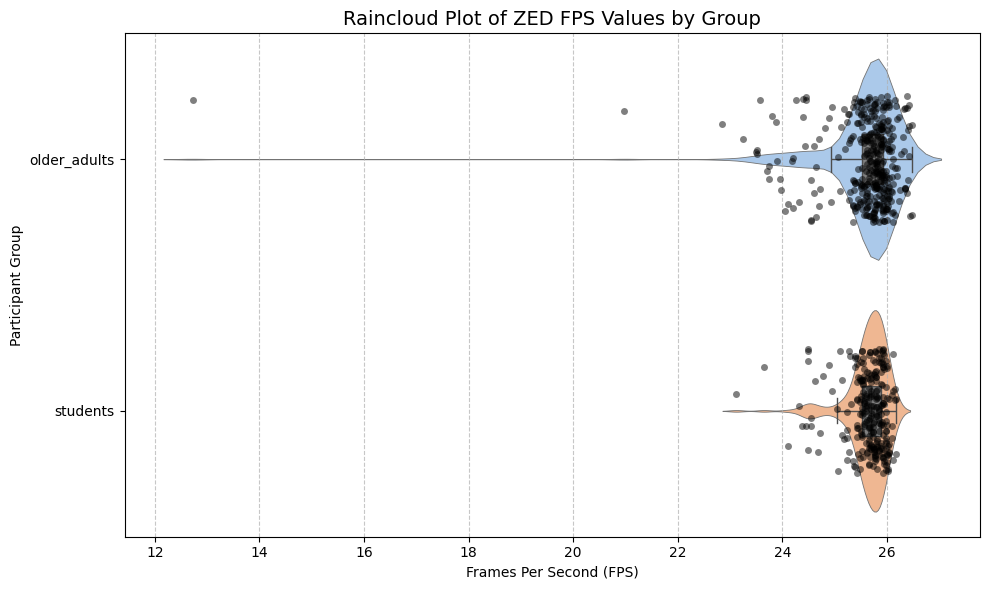

In [14]:
process_and_plot_fps(
    base_root1=os.path.join("..", "data", "raw", "older_adults"),
    base_root2=os.path.join("..", "data", "raw", "students")
)

## Smartphones data

### Older Adults

In [15]:
phones_data_length = get_total_time_per_trial_phones(participant_type="older_adults")

Extracting total time values from intermediate for participant_type: older_adults


Let's check the minimum length

In [16]:
phones_data_length.min()

participant name                   ann
phone                 ann-m_back_phone
trial name          ann-m_eyes_closed1
total_time                      24.969
dtype: object

That is fine, we can proceed  
We should remove the anomalies from earlier ('dida_eyes_closed5', 'yossef_eyes_open3')

In [31]:
INTERMEDIATE_DIR = os.path.join("..", "data", "intermediate", "older_adults")

# Files to delete
files_to_delete = [
    os.path.join(INTERMEDIATE_DIR, "dida", "dida_back_phone",  "dida_eyes_closed5.csv"),
    os.path.join(INTERMEDIATE_DIR, "dida", "dida_front_phone", "dida_eyes_closed5.csv"),
    os.path.join(INTERMEDIATE_DIR, "yossef", "yossef_back_phone",  "yossef_eyes_open3.csv"),
    os.path.join(INTERMEDIATE_DIR, "yossef", "yossef_front_phone", "yossef_eyes_open3.csv"),
]

for file_path in files_to_delete:
    if os.path.exists(file_path):
        os.remove(file_path)
        print(f"Deleted: {file_path}")
    else:
        print(f"Not found: {file_path}")

Not found: ..\data\intermediate\older_adults\dida\dida_back_phone\dida_eyes_closed5.csv
Not found: ..\data\intermediate\older_adults\dida\dida_front_phone\dida_eyes_closed5.csv
Not found: ..\data\intermediate\older_adults\yossef\yossef_back_phone\yossef_eyes_open3.csv
Not found: ..\data\intermediate\older_adults\yossef\yossef_front_phone\yossef_eyes_open3.csv


In [18]:
older_adults_phones = build_phones_dataset("older_adults")

In [19]:
older_adults_phones.head(2)

,participant name,state,trial,device,metric,value
0,ann,closed,1,back,AP MAD,0.078629
1,ann,closed,1,back,AP Max abs dev,1.073945


In [20]:
len(older_adults_phones)

6714

we had 38 participants * 2 states * 5 trials * 2 devices * 9 metric  
But, 1 participant didn't do 1 state (naftali - eyes closed) and we removed a total of 2 trials of other partcipants

In [21]:
38*2*5*2*9 - 1*1*5*2*9 - 2*1*1*2*9

6714

In [22]:
# Save it
out_path = os.path.join("..", "data", "processed", "older_adults", "phones_measurements.csv")
older_adults_phones.to_csv(out_path, index=False)

### Students

In [23]:
INTERMEDIATE_DIR = os.path.join("..", "data", "intermediate", "students")

# Files to delete
files_to_delete = [
    os.path.join(INTERMEDIATE_DIR, "6", "6_back_phone",  "6_eyes_closed3.csv"),
    os.path.join(INTERMEDIATE_DIR, "6", "6_front_phone", "6_eyes_closed3.csv"),
]

for file_path in files_to_delete:
    if os.path.exists(file_path):
        os.remove(file_path)
        print(f"Deleted: {file_path}")
    else:
        print(f"Not found: {file_path}")

Not found: ..\data\intermediate\students\6\6_back_phone\6_eyes_closed3.csv
Not found: ..\data\intermediate\students\6\6_front_phone\6_eyes_closed3.csv


In [24]:
students_phones = build_phones_dataset("students")

In [25]:
students_phones.head(2)

,participant name,state,trial,device,metric,value
0,1,closed,1,back,AP MAD,0.037315
1,1,closed,1,back,AP Max abs dev,0.218558


In [26]:
len(students_phones)

4860

we had 27 students * 2 states * 5 trials * 2 devices * 9 metric  
we removed 1 trial

In [27]:
27*2*5*2*9 - 1*1*1*2*9

4842

In [28]:
# Save it
out_path = os.path.join("..", "data", "processed", "students", "phones_measurements.csv")
students_phones.to_csv(out_path, index=False)